# Appendix C

In [ ]:
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import pickle

import galcheat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from madness_deblender.extraction import extract_cutouts

from madness_benchmark.utils import get_benchmark_config_path

%matplotlib inline

In [ ]:
with open(get_benchmark_config_path()) as f:
    benchmark_config = yaml.safe_load(f)
btksims_config = benchmark_config["btksims"]
survey_name = benchmark_config["survey_name"]
survey = galcheat.get_survey(benchmark_config["survey_name"])

In [ ]:
data_path = os.path.join(benchmark_config["RESULTS_PATH"][survey_name], "high_density")
run_name = "kl2"  # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
madness_results = []
scarlet_results = []
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
        )
    )

madness_results = pd.concat(madness_results)

In [ ]:
simulation_path = os.path.join(benchmark_config["TEST_DATA_PATH"][survey_name], "high")

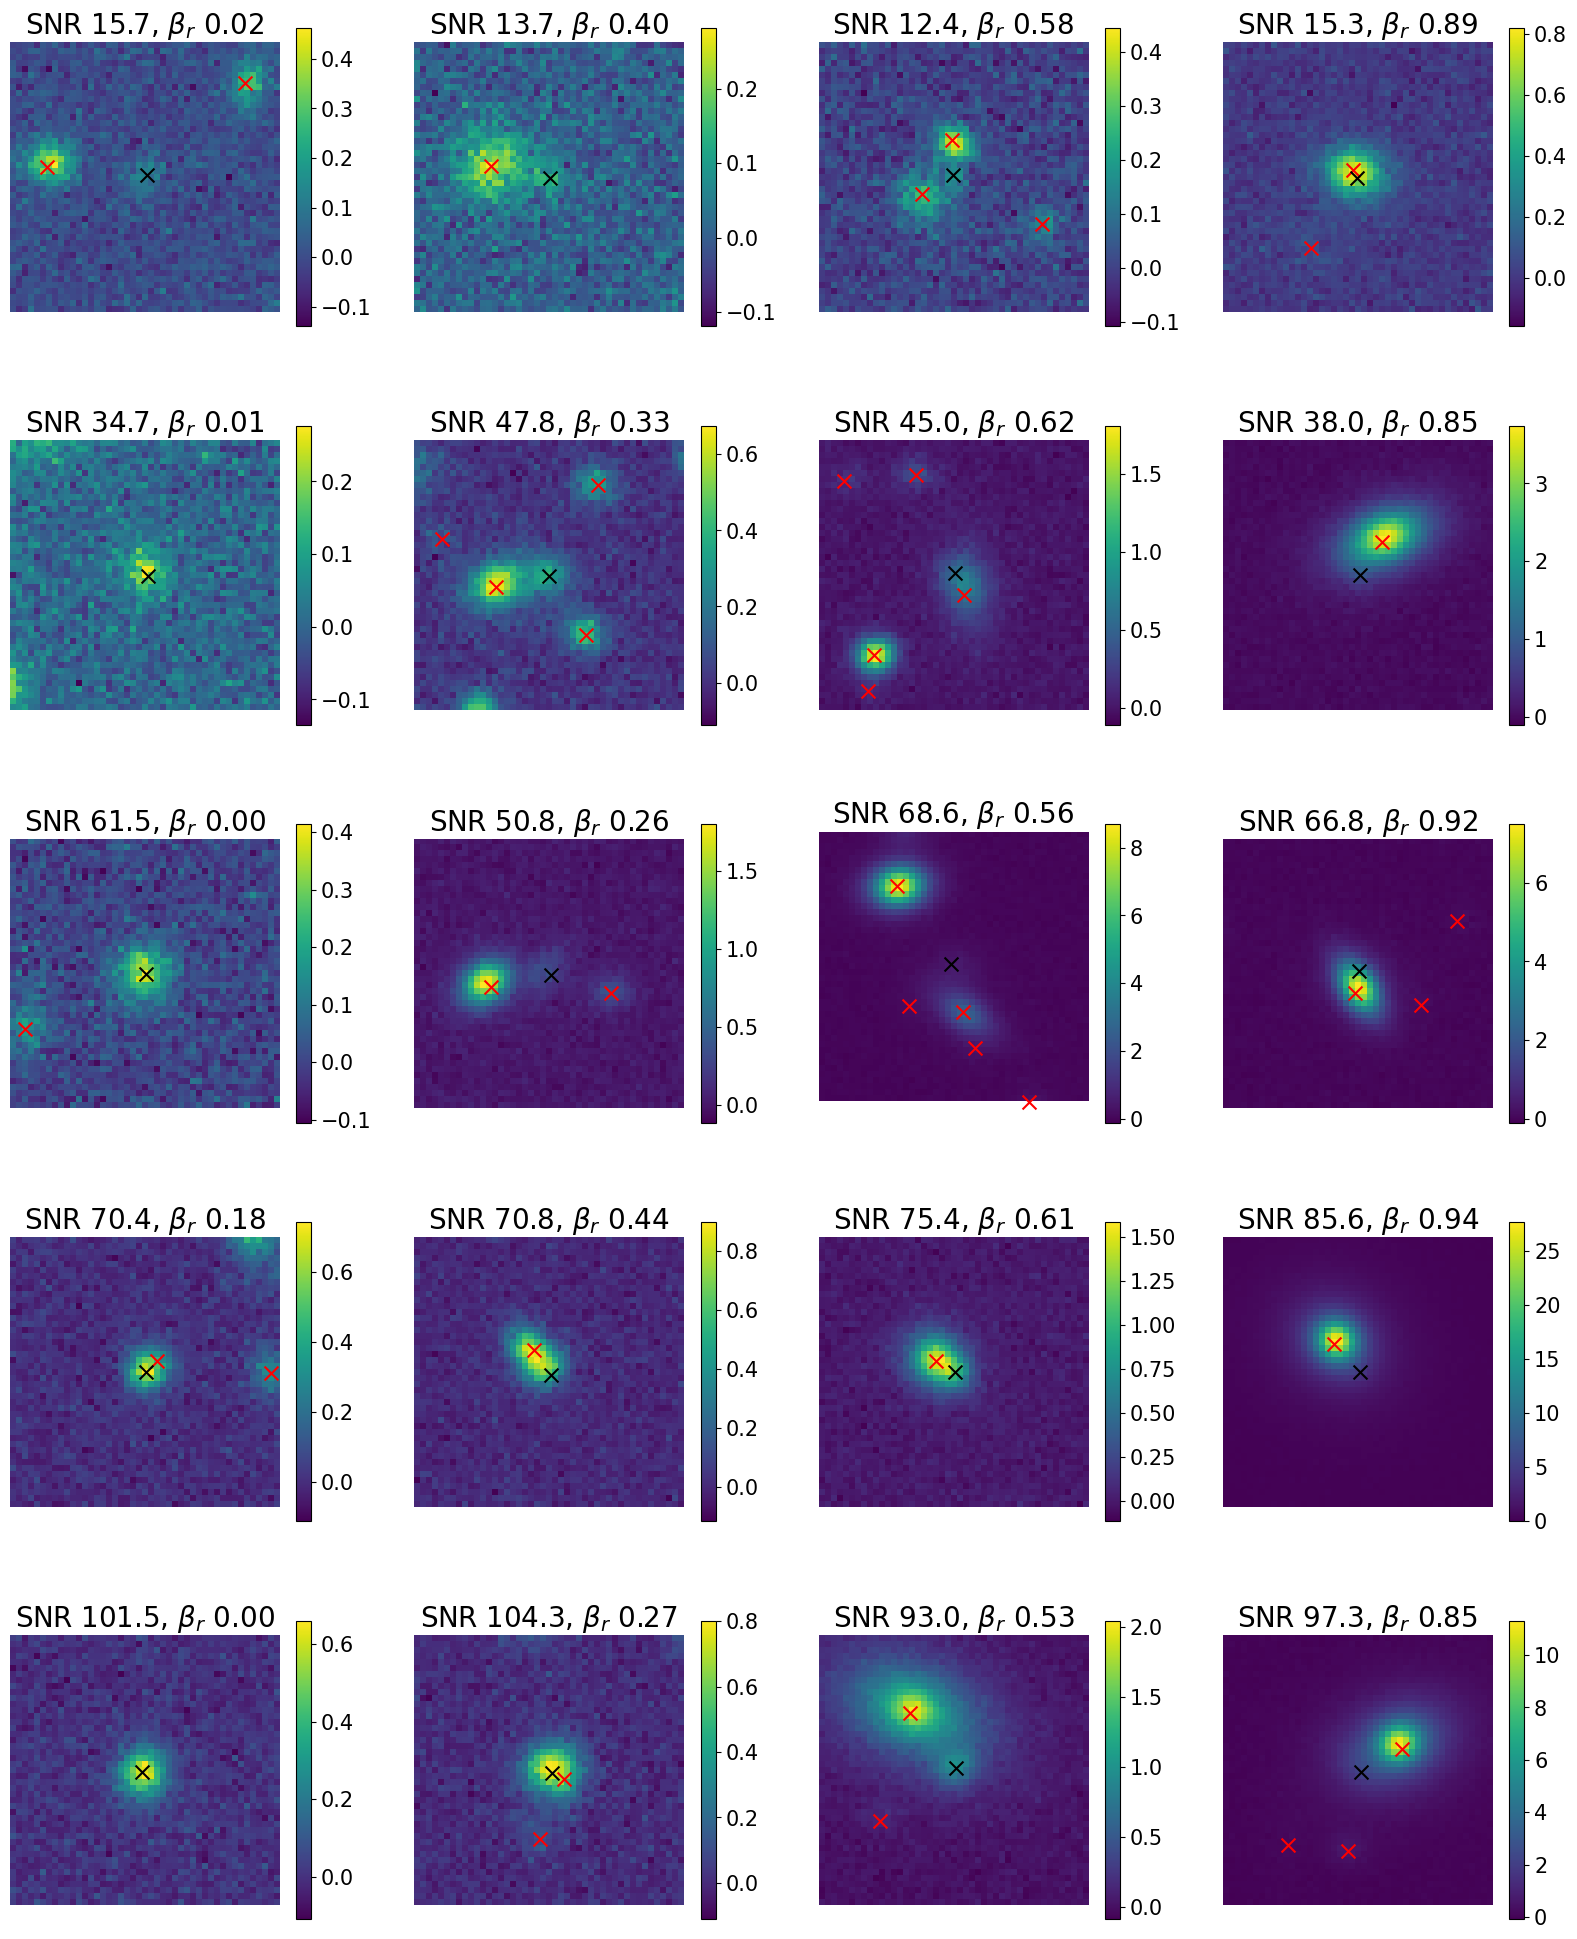

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(4 * 5, 5 * 5))
for snr_num, snr in enumerate(range(10, 110, 20)):
    # print(snr)
    mask = (madness_results["r_band_snr"] > snr) & (
        madness_results["r_band_snr"] < (snr + 20)
    )
    for blendedness_num, blendedness in enumerate(np.arange(0, 1, 0.25)):
        # print(blendedness)
        mask2 = (madness_results[mask]["r_blendedness"] > blendedness) & (
            madness_results[mask]["r_blendedness"] < (blendedness + 0.2)
        )

        row = madness_results[mask][mask2].sample(random_state=13)

        file_num = row["file_num"].values[0]
        field_num = row["field_num"].values[0]
        galaxy_num = row["galaxy_num"].values[0]

        # print(row['file_num'].values[0])
        file_name = os.path.join(
            simulation_path,
            str(file_num) + ".pkl",
        )
        with open(file_name, "rb") as f:
            blend = pickle.load(f)

        x_pos = blend.catalog_list[field_num]["y_peak"][galaxy_num]
        y_pos = blend.catalog_list[field_num]["x_peak"][galaxy_num]

        gal_blended = extract_cutouts(
            blend.blend_images[field_num],
            [(x_pos, y_pos)],
            distances_to_center=False,
            channel_last=False,
            cutout_size=45,
        )[0][0]

        # print(np.shape(gal_blended))

        im1 = ax[snr_num, blendedness_num].imshow(gal_blended[:, :, 2] / 10000)
        cbar = fig.colorbar(im1, ax=ax[snr_num, blendedness_num], shrink=0.9)
        cbar.ax.tick_params(labelsize=15)
        ax[snr_num, blendedness_num].set_title(
            r"SNR {:.1f}, $\beta_r$ {:.2f}".format(
                row["r_band_snr"].values[0], row["r_blendedness"].values[0]
            ),
            fontsize=20,
        )
        # ax[snr_num, blendedness_num].scatter(22, 22, c="r", marker="x")
        ax[snr_num, blendedness_num].axis("off")
        for current_galaxy in range(len(blend.catalog_list[field_num]["x_peak"])):

            if current_galaxy == galaxy_num:
                continue

            y_loc = (
                np.round(blend.catalog_list[field_num]["y_peak"][current_galaxy])
                + 22
                - x_pos
            )
            x_loc = (
                np.round(blend.catalog_list[field_num]["x_peak"][current_galaxy])
                + 22
                - y_pos
            )

            if ((x_loc > 0) & (x_loc < 45)) & ((y_loc > 0) & (y_loc < 45)):

                ax[snr_num, blendedness_num].scatter(
                    x_loc, y_loc, c="r", marker="x", s=100
                )

        # print(blendedness_cut)
        ax[snr_num, blendedness_num].scatter(
            np.round(blend.catalog_list[field_num]["y_peak"][galaxy_num]) + 22 - x_pos,
            np.round(blend.catalog_list[field_num]["x_peak"][galaxy_num]) + 22 - y_pos,
            c="black",
            marker="x",
            s=100,
        )
        f.close()
        del blend
plt.savefig("results/blendedness_variation_plot.pdf", format="pdf")
plt.show()

# Contamination Variation

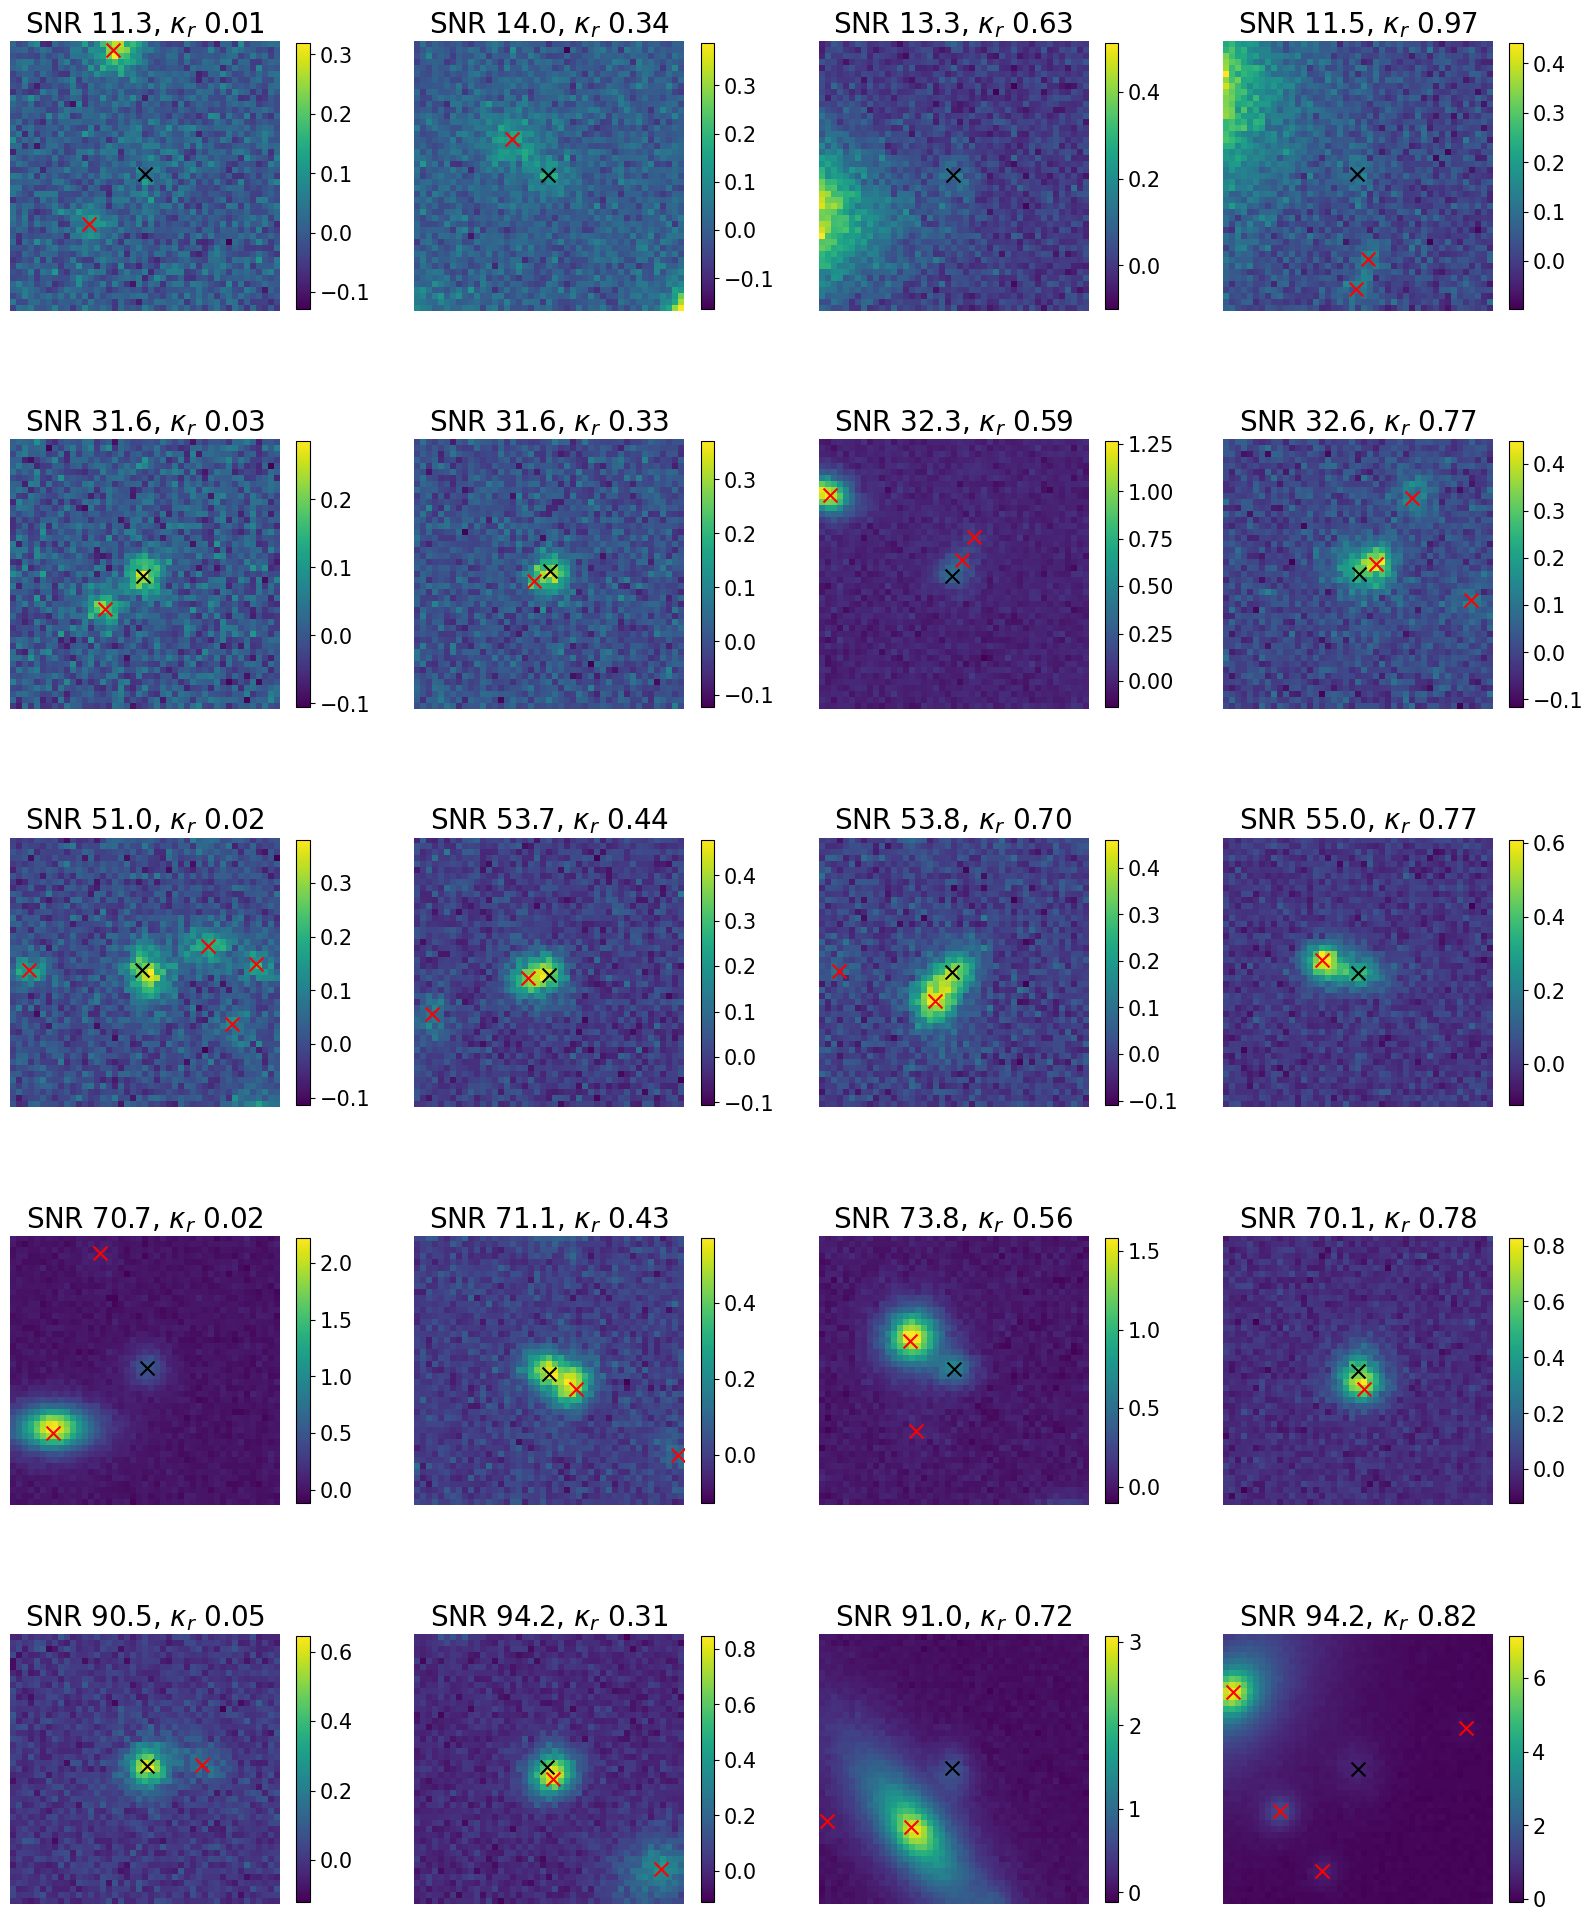

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(4 * 5, 5 * 5))
for snr_num, snr in enumerate(range(10, 110, 20)):
    # print(snr)
    mask = (madness_results["r_band_snr"] > snr) & (
        madness_results["r_band_snr"] < (snr + 5)
    )
    snr_cut = madness_results[mask]
    for contamination_num, contamination in enumerate(np.arange(0.01, 1.01, 0.25)):
        # print(contamination)
        mask2 = (snr_cut["r_contamination"] > contamination) & (
            snr_cut["r_contamination"] < (contamination + 0.25)
        )
        contamination_cut = snr_cut[mask2]

        row = contamination_cut.sample(random_state=7)

        file_num = row["file_num"].values[0]
        field_num = row["field_num"].values[0]
        galaxy_num = row["galaxy_num"].values[0]

        # print(row['file_num'].values[0])
        file_name = os.path.join(
            simulation_path,
            str(file_num) + ".pkl",
        )
        with open(file_name, "rb") as f:
            blend = pickle.load(f)

        x_pos = blend.catalog_list[field_num]["y_peak"][galaxy_num]
        y_pos = blend.catalog_list[field_num]["x_peak"][galaxy_num]

        gal_blended = extract_cutouts(
            blend.blend_images[field_num],
            [(x_pos, y_pos)],
            distances_to_center=False,
            channel_last=False,
            cutout_size=45,
        )[0][0]

        # print(np.shape(gal_enended))

        im1 = ax[snr_num, contamination_num].imshow(gal_blended[:, :, 2] / 10000)
        cbar = fig.colorbar(im1, ax=ax[snr_num, contamination_num], shrink=0.8)
        cbar.ax.tick_params(labelsize=15)
        ax[snr_num, contamination_num].set_title(
            r"SNR {:.1f}, $\kappa_r$ {:.2f}".format(
                row["r_band_snr"].values[0], row["r_contamination"].values[0]
            ),
            fontsize=20,
        )
        # ax[snr_num, contamination_num].scatter(22, 22, c="r", marker="x")
        ax[snr_num, contamination_num].axis("off")
        for current_galaxy in range(len(blend.catalog_list[field_num]["x_peak"])):

            if current_galaxy == galaxy_num:
                continue

            y_loc = (
                np.round(blend.catalog_list[field_num]["y_peak"][current_galaxy])
                + 22
                - x_pos
            )
            x_loc = (
                np.round(blend.catalog_list[field_num]["x_peak"][current_galaxy])
                + 22
                - y_pos
            )

            if ((x_loc > 0) & (x_loc < 44)) & ((y_loc > 0) & (y_loc < 44)):

                ax[snr_num, contamination_num].scatter(
                    x_loc, y_loc, c="r", marker="x", s=100
                )

        # print(contamination_cut)
        ax[snr_num, contamination_num].scatter(
            np.round(blend.catalog_list[field_num]["y_peak"][galaxy_num]) + 22 - x_pos,
            np.round(blend.catalog_list[field_num]["x_peak"][galaxy_num]) + 22 - y_pos,
            c="black",
            marker="x",
            s=100,
        )
        f.close()
        del blend

plt.savefig("results/contamination_variation_plot.pdf", format="pdf")
plt.show()